In [101]:
import pickle
import os
from glob import glob
from datetime import datetime


import imutils
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

## Generate Tags

In [5]:
tags = {}

for filepath in glob('data/*.txt'):
    filename = os.path.basename(filepath).replace('.txt', '')
    classification = eval(filename.split('_')[0])
    
    img_name = filename.split('_')[1]
    tags[img_name] = classification

## Reducing False Positives with a Pre-Trained Model

In [12]:
# Load Model
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
net = cv2.dnn.readNetFromCaffe('../app/model-files/MobileNetSSD_deploy.prototxt.txt', '../app/model-files/MobileNetSSD_deploy.caffemodel')

In [13]:
def get_person_prob(image):
    resized = cv2.resize(image, (300, 300))
    blob = cv2.dnn.blobFromImage(resized, 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()
    probs = [
        detections[0, 0, i, 2] if int(detections[0, 0, i, 1]) == 15 else 0 
        for i in np.arange(0, detections.shape[2])
    ]
    person_prob = max(probs)
    return person_prob

## Generate Metadata - Image Classifcations

In [42]:
meta = {}

files = glob('data/*.pkl')
for i, filepath in enumerate(files):
    print(f"{i}: processing {filepath}")
    filename = os.path.basename(filepath).replace('.pkl', '')
    data = pickle.load(open(filepath, 'rb'))
    
    classification = True if filename.split('_')[0] == 'occupied' else False        
    img_name = filename.split('_')[1]
    
    # remove anything predicted as occupied but not tagged
    if classification and img_name not in tags:
        print (f'Missing tag for {img_name}')
        continue
        
    meta[img_name] = {}
    meta[img_name]['pred'] = classification
    meta[img_name]['actual'] = tags.get(img_name, False)
    meta[img_name]['model_score'] = get_person_prob(data['frame'])
    all_scores = []
    for frame in data['frames']:
        all_scores.append(get_person_prob(frame))
    meta[img_name]['all_scores'] = all_scores

0: processing data/unoccupied_2018-11-06-11-41-59.875928.pkl
1: processing data/occupied_2018-11-08-20-15-41.160421.pkl
2: processing data/occupied_2018-11-08-14-31-08.719194.pkl
3: processing data/occupied_2018-11-08-11-06-48.671914.pkl
4: processing data/unoccupied_2018-11-08-13-21-13.176455.pkl
5: processing data/occupied_2018-11-08-19-44-36.661026.pkl
6: processing data/unoccupied_2018-11-05-06-54-11.064602.pkl
7: processing data/occupied_2018-11-08-11-02-18.913597.pkl
8: processing data/occupied_2018-11-08-20-15-31.062825.pkl
9: processing data/occupied_2018-11-08-20-16-49.955185.pkl
10: processing data/unoccupied_2018-11-07-13-40-43.983553.pkl
11: processing data/unoccupied_2018-11-08-12-41-12.924148.pkl
12: processing data/occupied_2018-11-07-18-57-42.168398.pkl
13: processing data/unoccupied_2018-11-05-02-24-09.978770.pkl
14: processing data/unoccupied_2018-11-07-12-00-43.172665.pkl
15: processing data/unoccupied_2018-11-08-17-51-14.836108.pkl
16: processing data/unoccupied_201

In [44]:
pd_data = {
    'img_name': [],
    'pred': [],
    'actual': [],
    'model_score': [],
    'all_scores': []
}
for img_name, data in meta.items():
    pd_data['img_name'].append(img_name)
    for key, value in data.items():
        pd_data[key].append(value)
        
df = pd.DataFrame(pd_data)

In [102]:
df['motion_pred'] = df.pred.astype(int)
df['last_30_mean'] = df.all_scores.apply(lambda scores: np.mean(scores))
df['pred'] = df.pred.astype(int)
df['actual'] = df.actual.astype(int)
df['ts'] = df['img_name'].apply(lambda dt_str: datetime.strptime(dt_str, '%Y-%m-%d-%H-%M-%S.%f'))
df.head()

,img_name,pred,actual,model_score,all_scores,motion_pred,last_30_mean,ts
0,2018-11-06-11-41-59.875928,0,0,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.000000,2018-11-06 11:41:59.875928
1,2018-11-08-20-15-41.160421,1,1,0.623937,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.27801758, 0.7898...",1,0.396500,2018-11-08 20:15:41.160421
2,2018-11-08-14-31-08.719194,1,1,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0.000000,2018-11-08 14:31:08.719194
3,2018-11-08-11-06-48.671914,1,1,0.573568,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.282077,2018-11-08 11:06:48.671914
4,2018-11-08-13-21-13.176455,0,0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.000000,2018-11-08 13:21:13.176455


In [162]:
df.groupby(['pred', 'actual']).last_30_mean.agg({'mean': 'mean', 'cnt': 'count'}).reset_index()

/Users/ianwhitestone/miniconda3/envs/rpi/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


,pred,actual,mean,cnt
0,0,0,0.000000,235
1,0,1,0.793802,1
2,1,0,0.000000,6
3,1,1,0.222358,269


In [60]:
## False negative
# df[(df.pred == False) & (df.model_score > 0)]

df.loc[df.img_name=='2018-11-06-11-11-59.527707', 'actual'] = 1

In [85]:
## Falsely tagged as negative

# switch actual tagging to True
fns = ['2018-11-08-11-04-10.878601','2018-11-08-11-01-12.121449','2018-11-07-18-49-09.353242','2018-11-08-20-13-58.875368','2018-11-08-11-12-14.001166']
df.loc[df.img_name.apply(lambda x: any([x in y for y in fns])), 'actual'] = 1

In [144]:
df[(df.pred == 1) & (df.actual == 1) & (df.last_30_mean == 0)].shape # 92 (where no people are classifed, but image was tag as occupied..)

(92, 8)

In [106]:
df.head()

,img_name,pred,actual,model_score,all_scores,motion_pred,last_30_mean,ts
0,2018-11-06-11-41-59.875928,0,0,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.000000,2018-11-06 11:41:59.875928
1,2018-11-08-20-15-41.160421,1,1,0.623937,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.27801758, 0.7898...",1,0.396500,2018-11-08 20:15:41.160421
2,2018-11-08-14-31-08.719194,1,1,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0.000000,2018-11-08 14:31:08.719194
3,2018-11-08-11-06-48.671914,1,1,0.573568,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.282077,2018-11-08 11:06:48.671914
4,2018-11-08-13-21-13.176455,0,0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.000000,2018-11-08 13:21:13.176455


In [109]:
df2.index = df2.ts
df2.sort_index(ascending=True, inplace=True)

In [157]:
df2['rolling_last_30_mean'] = df2.rolling('300s', min_periods=1).last_30_mean.mean()

In [158]:
df2[(df2.pred == 1) & (df2.actual == 1) & (df2.last_30_mean == 0) & (df2.rolling_last_30_mean == 0)].head()

,img_name,pred,actual,model_score,all_scores,motion_pred,last_30_mean,ts,rolling_last_30_mean
ts,,,,,,,,,


In [161]:
start = datetime.strptime('2018-11-08-18-58', '%Y-%m-%d-%H-%M')
end = datetime.strptime('2018-11-08-19-02', '%Y-%m-%d-%H-%M')
df2[(df2.index >= start) & (df2.index <= end)]

,img_name,pred,actual,model_score,all_scores,motion_pred,last_30_mean,ts,rolling_last_30_mean
ts,,,,,,,,,
2018-11-08 18:58:20.317003,2018-11-08-18-58-20.317003,1,1,0.982938,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.168161,2018-11-08 18:58:20.317003,0.206762
2018-11-08 18:58:30.402650,2018-11-08-18-58-30.402650,1,1,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.000000,2018-11-08 18:58:30.402650,0.155072
2018-11-08 18:58:40.449538,2018-11-08-18-58-40.449538,1,1,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0.000000,2018-11-08 18:58:40.449538,0.124057
2018-11-08 18:58:50.499942,2018-11-08-18-58-50.499942,1,1,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.000000,2018-11-08 18:58:50.499942,0.103381
2018-11-08 18:59:11.641485,2018-11-08-18-59-11.641485,1,1,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0.000000,2018-11-08 18:59:11.641485,0.088612
2018-11-08 18:59:22.693702,2018-11-08-18-59-22.693702,1,1,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0.000000,2018-11-08 18:59:22.693702,0.077536
2018-11-08 18:59:41.099786,2018-11-08-18-59-41.099786,1,1,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0.000000,2018-11-08 18:59:41.099786,0.068921
2018-11-08 18:59:51.103609,2018-11-08-18-59-51.103609,1,1,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0.000000,2018-11-08 18:59:51.103609,0.062029
2018-11-08 19:00:05.884721,2018-11-08-19-00-05.884721,1,1,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0.000000,2018-11-08 19:00:05.884721,0.056390


## Blended Model

In [165]:
# If person in any frames in last 30 seconds
df2['person_pred'] = (df2.last_30_mean > 0).astype(int)


df2['blended_pred'] = pd.Series(0, index=df2.index)
df2.loc[(df2.motion_pred == 1) & (df2.person_pred == 1), 'blended_pred'] = 1

In [213]:

# 93 missed are actually cases where it tagged someone in the frame within the last 5 minutes,
# but then person was working in the corner of the picture in the kitchen and their head
# was not being picked up by the people classifier
# technically can ignore these, since the system has already correct flagged someone as being
# present earlier when they walked into the frame

 #.last_30_mean.agg({'mean': 'mean', 'cnt': 'count'}).reset_index()
    
# df2.groupby(['blended_pred', 'actual']).pred.count().reset_index(name='cnt')
df2.groupby(['motion_pred', 'person_pred', 'actual']).pred.count().reset_index(name='cnt')

,motion_pred,person_pred,actual,cnt
0,0,0,0,235
1,0,1,1,1
2,1,0,0,6
3,1,0,1,92
4,1,1,1,177


## Comparing Model Runtimes

In [140]:
# %timeit -n 10 get_person_prob(oth_data['frame'])

%time [get_person_prob(oth_data['frame']) for x in range(0, 10)]

CPU times: user 1.41 s, sys: 25.6 ms, total: 1.43 s
Wall time: 598 ms


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Inspecting Some Files

True

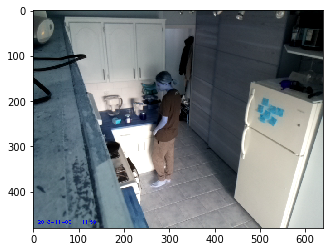

In [219]:
img_name = 'unoccupied_2018-11-06-11-11-59.527707' # False Negative
sample_data = pickle.load(open(f'data/{img_name}.pkl', 'rb'))
frame = sample_data['frames'][-1]

plt.imshow(frame)
# plt.imshow(sample_data['frame_delta'])

cv2.imwrite('fn.jpg', frame)
# for frame in sample_data['frames']:
#     print(get_person_prob(frame))

True

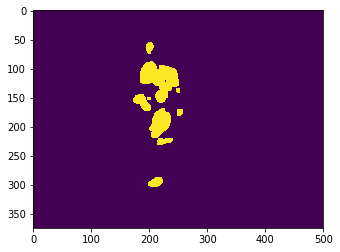

In [220]:
img_name = 'unoccupied_2018-11-06-11-11-59.527707' # False Negative
sample_data = pickle.load(open(f'data/{img_name}.pkl', 'rb'))

plt.imshow(sample_data['frame_delta'])

cv2.imwrite('fn_delta.jpg', sample_data['frame_delta'])

In [222]:
sample_data['contours']

[{'coords': (199, 287, 25, 17), 'size': 293.5},
 {'coords': (213, 220, 28, 13), 'size': 225.0},
 {'coords': (248, 170, 10, 12), 'size': 89.0},
 {'coords': (200, 169, 38, 52), 'size': 1242.0},
 {'coords': (197, 149, 7, 6), 'size': 27.0},
 {'coords': (173, 144, 30, 30), 'size': 480.5},
 {'coords': (247, 135, 7, 7), 'size': 35.0},
 {'coords': (185, 88, 66, 72), 'size': 2651.5},
 {'coords': (195, 55, 13, 20), 'size': 186.5}]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.75209486
0.8638677
0.83701575
0.73305446
0.875869
0.98293847


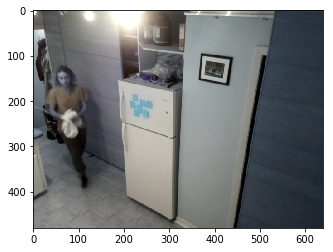

In [203]:
img_name = 'unoccupied_2018-11-06-11-11-59.527707' # False Negative
img_name = 'occupied_2018-11-08-18-58-20.317003'
sample_data = pickle.load(open(f'data/{img_name}.pkl', 'rb'))
frame = sample_data['frames'][-1]

plt.imshow(frame)
# plt.imshow(sample_data['frame_delta'])

for frame in sample_data['frames']:
    print(get_person_prob(frame))

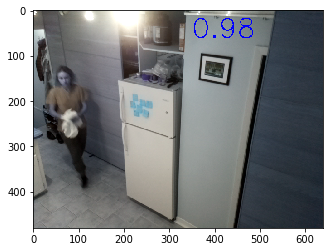

In [202]:
cv2.putText(frame, '0.98', (350, 60),
            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

plt.imshow(frame)

In [205]:
height , width , layers =  frame.shape
video = cv2.VideoWriter('video.mp4',-1,0.1,(width,height))

for frame in sample_data['frames']:
    prob = round(get_person_prob(frame), 2)
    
    cv2.putText(frame, str(prob), (350, 60),
            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
    
    video.write(frame)

cv2.destroyAllWindows()
video.release()


In [9]:
sample_data.keys()

dict_keys(['frame', 'frames', 'frame_delta', 'avg', 'contours', 'pir', 'classification', 'ts'])

In [24]:
tp_pkl_file = open('tp_example.pkl', 'rb')
fp_pkl_file = open('fp_example.pkl', 'rb')
oth_pkl_file = open('data/occupied_2018-11-02-23-08-31.498366.pkl', 'rb')

tp_data = pickle.load(tp_pkl_file)
fp_data = pickle.load(fp_pkl_file)
oth_data = pickle.load(oth_pkl_file)

In [14]:
print (np.mean(tp_data['pir']))
print (np.mean(tp_data['pir'][-10:]))

0.04
1.0


In [15]:
print (np.mean(fp_data['pir']))
print (np.mean(fp_data['pir'][-10:]))

0.0
0.0


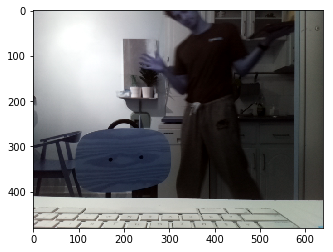

In [23]:
plt.imshow(tp_data['frame'])

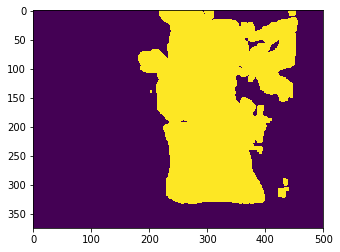

In [25]:
plt.imshow(tp_data['frame_delta'])

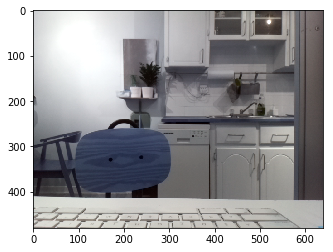

In [26]:
plt.imshow(fp_data['frame'])

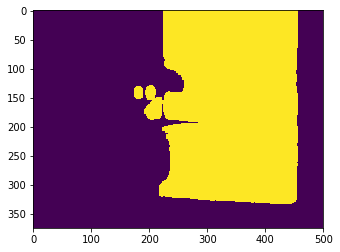

In [27]:
plt.imshow(fp_data['frame_delta'])

plt.imshow(oth_data['frame'])

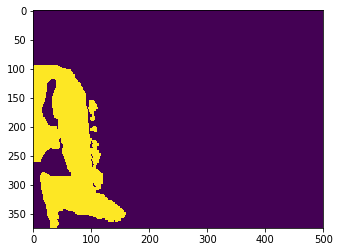

In [26]:
plt.imshow(oth_data['frame_delta'])

In [31]:
cv2.imwrite('oth.jpg', oth_data['frame'])

True

## Background Substraction Demo

In [127]:
frame1 = cv2.imread('background.png')
frame2 = cv2.imread('person.png')

In [128]:
frame = imutils.resize(frame1, height=270)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
avg = cv2.GaussianBlur(gray, (21, 21), 0).astype("float")
avg = np.insert(avg, 499, 60, axis=1)

In [129]:
frame = imutils.resize(frame2, height=270)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (21, 21), 0)


frame_delta = cv2.absdiff(gray_blur, cv2.convertScaleAbs(avg))

thresh = cv2.threshold(frame_delta, 5, 255, cv2.THRESH_BINARY)[1]
dilated = cv2.dilate(thresh, None, iterations=2)
contours = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)


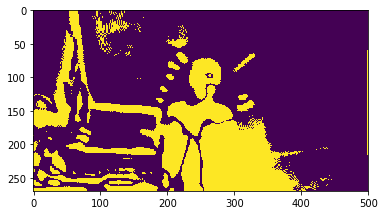

In [135]:
plt.imshow(thresh)

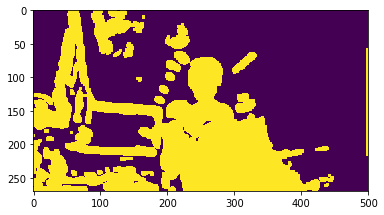

In [131]:
plt.imshow(dilated)

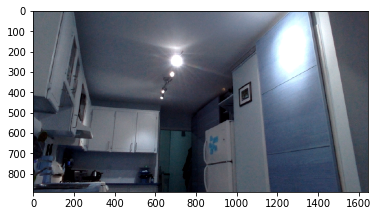

In [132]:
plt.imshow(frame1)

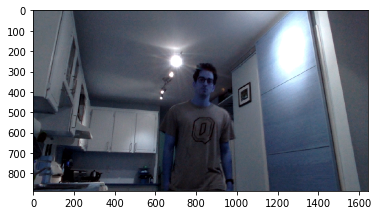

In [133]:
plt.imshow(frame2)